In [31]:
import os
import glob
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve

from skimage.filters import threshold_otsu

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pickle

In [32]:
# =========================================================
# 1. LOAD DATASET
# =========================================================
def load_wrist_dataset_images(
    data_root="../Multispectral Palmprint Database/NIR",
    img_size=(256, 256),
    num_persons=30
):
    """
    Returns:
        X_images: (N, H, W, 1) float32 in [0,1]
        y:        (N,) int64 labels
        label_names: list of folder names (e.g. "0001", "0002", ...)
    """
    X = []
    y = []
    label_names = []

    all_dirs = sorted(
        d for d in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, d))
    )
    person_dirs = all_dirs[:num_persons]
    print(f"Using persons: {person_dirs}")

    for label_idx, person in enumerate(person_dirs):
        label_names.append(person)
        folder = os.path.join(data_root, person)

        img_paths = []
        for ext in ("*.bmp", "*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff"):
            img_paths.extend(glob.glob(os.path.join(folder, ext)))

        if not img_paths:
            print(f"Warning: no images found in {folder}")
            continue

        for path in img_paths:
            img = Image.open(path).convert("L")
            img = img.resize(img_size)
            arr = np.array(img, dtype=np.float32) / 255.0  # [H,W]
            X.append(arr[..., np.newaxis])                 # [H,W,1]
            y.append(label_idx)

    X = np.stack(X).astype(np.float32)          # (N,H,W,1)
    y = np.array(y, dtype=np.int64)            # (N,)
    return X, y, label_names


IMG_SIZE = (256, 256)
X_img, y, label_names = load_wrist_dataset_images(
    data_root="../Multispectral Palmprint Database/NIR",
    img_size=IMG_SIZE,
    num_persons=30,
)
print("X_img shape:", X_img.shape)   # (N, 256, 256, 1)
print("y shape:", y.shape)
print("#classes:", len(label_names))

# =========================================================
# 2. TRAIN / TEST SPLIT (on images)
# =========================================================
X_train_img, X_test_img, y_train, y_test = train_test_split(
    X_img, y, test_size=0.2, stratify=y, random_state=42
)
print("Train imgs:", X_train_img.shape[0], "Test imgs:", X_test_img.shape[0])

Using persons: ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030']
X_img shape: (360, 256, 256, 1)
y shape: (360,)
#classes: 30
Train imgs: 288 Test imgs: 72


X_train_img_clahe shape: (288, 256, 256, 1)
X_test_img_clahe shape: (72, 256, 256, 1)
y_train_mask shape: (288, 256, 256, 1)


Model: "u_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_15[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_57[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 128, 128,  │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_21… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_59[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 64, 64,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_22… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_61[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 32, 32,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_23… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_63[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 64, 64,    │          0 │ conv2d_64[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 64, 64,    │          0 │ up_sampling2d_9[… │
│ (Concatenate)       │ 192)              │            │ conv2d_62[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 64, 64,    │    110,656 │ concatenate_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_65[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_10    │ (None, 128, 128,  │          0 │ conv2d_66[0][0] 

 Total params: 487,009 (1.86 MB)

 Trainable params: 487,009 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
36/36 - 20s - 543ms/step - accuracy: 0.7567 - loss: 0.5011 - val_accuracy: 0.9399 - val_loss: 0.1630
Epoch 2/50
36/36 - 12s - 345ms/step - accuracy: 0.9490 - loss: 0.1417 - val_accuracy: 0.9660 - val_loss: 0.0888
Epoch 3/50
36/36 - 12s - 344ms/step - accuracy: 0.9568 - loss: 0.1240 - val_accuracy: 0.9641 - val_loss: 0.0954
Epoch 4/50
36/36 - 12s - 340ms/step - accuracy: 0.9702 - loss: 0.0787 - val_accuracy: 0.9735 - val_loss: 0.0674
Epoch 5/50
36/36 - 12s - 341ms/step - accuracy: 0.9750 - loss: 0.0629 - val_accuracy: 0.9721 - val_loss: 0.0696
Epoch 6/50
36/36 - 12s - 340ms/step - accuracy: 0.9762 - loss: 0.0591 - val_accuracy: 0.9780 - val_loss: 0.0531
Epoch 7/50
36/36 - 12s - 338ms/step - accuracy: 0.9779 - loss: 0.0543 - val_accuracy: 0.9784 - val_loss: 0.0520
Epoch 8/50
36/36 - 12s - 341ms/step - accuracy: 0.9801 - loss: 0.0483 - val_accuracy: 0.9811 - val_loss: 0.0456
Epoch 9/50
36/36 - 12s - 341ms/step - accuracy: 0.9810 - loss: 0.0464 - val_accuracy: 0.9816 - val_loss:

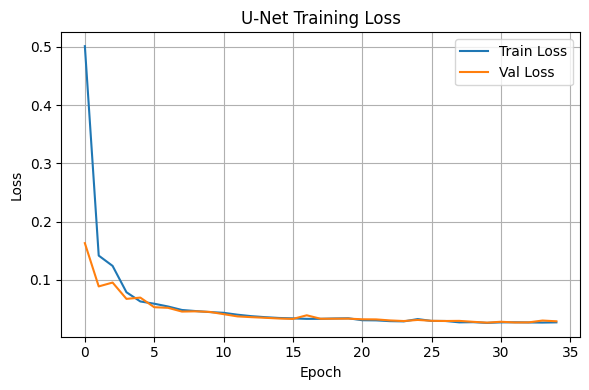

In [34]:
# =========================================================
# 3. U-NET FOR SEGMENTATION
#    (use CLAHE-enhanced images + Otsu masks as labels)
# =========================================================
import cv2

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    image: 2D array (H,W) float32 in [0,1]
    returns: CLAHE-enhanced image in [0,1]
    """
    img_uint8 = (image * 255).astype(np.uint8)
    clahe = cv2.createCLAHE(
        clipLimit=clip_limit,
        tileGridSize=tile_grid_size
    )
    cl = clahe.apply(img_uint8)
    return cl.astype(np.float32) / 255.0


def apply_clahe_batch(X_images, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    X_images: (N,H,W,1) float32 in [0,1]
    returns: CLAHE-enhanced images (N,H,W,1)
    """
    out = []
    for img in X_images:
        arr = img[..., 0]                 # (H,W)
        cl = apply_clahe(arr, clip_limit, tile_grid_size)
        out.append(cl[..., np.newaxis])   # (H,W,1)
    return np.stack(out).astype(np.float32)



# First, apply CLAHE to train & test images
X_train_img_clahe = apply_clahe_batch(X_train_img)  # (N_train,H,W,1)
X_test_img_clahe  = apply_clahe_batch(X_test_img)   # (N_test,H,W,1)

print("X_train_img_clahe shape:", X_train_img_clahe.shape)
print("X_test_img_clahe shape:", X_test_img_clahe.shape)


def create_clahe_otsu_masks(X_images_clahe):
    """
    Given CLAHE images (N,H,W,1) in [0,1],
    returns binary masks (N,H,W,1) using per-image Otsu on CLAHE image.
    """
    masks = []
    for img in X_images_clahe:
        arr = img[..., 0]                 # (H,W), CLAHE-enhanced
        th = threshold_otsu(arr)
        mask = (arr >= th).astype(np.float32)
        masks.append(mask[..., np.newaxis])
    return np.stack(masks).astype(np.float32)


y_train_mask = create_clahe_otsu_masks(X_train_img_clahe)
y_test_mask  = create_clahe_otsu_masks(X_test_img_clahe)

print("y_train_mask shape:", y_train_mask.shape)


def build_unet(input_shape=(256, 256, 1)):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    # Block 1: Two conv layers with 16 filters each, kernel size 3×3, ReLU activation, (Features: 16 channels)
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)    # p1 is max-pooled → spatial size halves to 128×128
    # Block 2: 32 filters (Features: 32 channels)
    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)    # size halves to 64×64
    # Block 3: 64 filters (Features: 64 channels)
    c3 = layers.Conv2D(64, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(64, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)    # size halves to 32×32   

    # Bottleneck
    # Feature map size: 32×32, Channels: 128, combines information from the whole image, but at low resolution.
    bn = layers.Conv2D(128, 3, activation="relu", padding="same")(p3)
    bn = layers.Conv2D(128, 3, activation="relu", padding="same")(bn)

    # Decoder
    u3 = layers.UpSampling2D((2, 2))(bn)
    u3 = layers.Concatenate()([u3, c3])
    c4 = layers.Conv2D(64, 3, activation="relu", padding="same")(u3)
    c4 = layers.Conv2D(64, 3, activation="relu", padding="same")(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv2D(32, 3, activation="relu", padding="same")(u2)
    c5 = layers.Conv2D(32, 3, activation="relu", padding="same")(c5)

    u1 = layers.UpSampling2D((2, 2))(c5)
    u1 = layers.Concatenate()([u1, c1])
    c6 = layers.Conv2D(16, 3, activation="relu", padding="same")(u1)
    c6 = layers.Conv2D(16, 3, activation="relu", padding="same")(c6)

    # Output layer: 1 filter, kernel size 1×1, sigmoid activation. size (256×256×1)
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c6)

    model = keras.Model(inputs, outputs, name="u_net")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


unet = build_unet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
unet.summary()

# Train U-Net with early stopping
batch_size = 8
epochs = 50

early_stop_unet = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_unet = unet.fit(
    X_train_img, y_train_mask,
    validation_data=(X_test_img, y_test_mask),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stop_unet],
    verbose=2,
)

# Optional: plot U-Net loss curves
plt.figure(figsize=(6,4))
plt.plot(history_unet.history["loss"], label="Train Loss")
plt.plot(history_unet.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("U-Net Training Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# =========================================================
# 4. USE TRAINED U-NET TO GENERATE MASKS FOR ALL IMAGES
# =========================================================
X_all_masks = unet.predict(X_img, batch_size=8, verbose=0)
# binarise masks for SNN input (optional)
X_all_masks_bin = (X_all_masks >= 0.5).astype(np.float32)

# Split masks according to same indices as images
# (we can recompute using train_test_split on indices)
idx = np.arange(len(X_img))
train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=y, random_state=42)

X_train_mask_snn = X_all_masks_bin[train_idx]
X_test_mask_snn  = X_all_masks_bin[test_idx]
y_train_snn = y[train_idx]
y_test_snn  = y[test_idx]

print("Train masks for SNN:", X_train_mask_snn.shape)
print("Test masks for SNN:", X_test_mask_snn.shape)


Train masks for SNN: (288, 256, 256, 1)
Test masks for SNN: (72, 256, 256, 1)


In [38]:
# =========================================================
# 5. CREATE PAIRS FOR SIAMESE NETWORK
# =========================================================
def make_pairs(images, labels, num_pos_per_img=1, num_neg_per_img=1, rng_seed=42):
    """
    Creates positive and negative pairs for Siamese training.
    images : (N,H,W,1)
    labels : (N,)
    """
    rng = np.random.default_rng(rng_seed)
    images = np.asarray(images)
    labels = np.asarray(labels)

    # map from label -> indices
    label_to_indices = {}
    for i, lab in enumerate(labels):
        label_to_indices.setdefault(int(lab), []).append(i)

    all_indices = np.arange(len(labels))
    pair_left = []
    pair_right = []
    pair_y = []

    for i in range(len(labels)):
        lab = int(labels[i])

        # positive pairs
        same_indices = label_to_indices[lab]
        same_indices = [j for j in same_indices if j != i]
        for _ in range(num_pos_per_img):
            if same_indices:
                j = int(rng.choice(same_indices))
                pair_left.append(images[i])
                pair_right.append(images[j])
                pair_y.append(1)

        # negative pairs
        diff_labels = [l for l in label_to_indices.keys() if l != lab]
        for _ in range(num_neg_per_img):
            neg_lab = int(rng.choice(diff_labels))
            j = int(rng.choice(label_to_indices[neg_lab]))
            pair_left.append(images[i])
            pair_right.append(images[j])
            pair_y.append(0)

    pair_left = np.stack(pair_left).astype(np.float32)
    pair_right = np.stack(pair_right).astype(np.float32)
    pair_y = np.array(pair_y, dtype=np.float32)

    return [pair_left, pair_right], pair_y


(train_pairs, y_train_pairs) = make_pairs(X_train_mask_snn, y_train_snn,
                                          num_pos_per_img=3, num_neg_per_img=3)
(test_pairs, y_test_pairs) = make_pairs(X_test_mask_snn, y_test_snn,
                                        num_pos_per_img=3, num_neg_per_img=3)

print("Train pairs:", train_pairs[0].shape, "labels:", y_train_pairs.shape)
print("Test  pairs:", test_pairs[0].shape, "labels:", y_test_pairs.shape)

input_shape_mask = (IMG_SIZE[0], IMG_SIZE[1], 1)

# =========================================================
# 6. BUILD SIAMESE NETWORK
# =========================================================
# Contrastive Loss (Hadsell-et-al.)
def contrastive_loss(y_true, y_pred, margin=1.0):
    """
    y_true: 1 = positive pair (same person), 
            0 = negative pair (different persons)
    y_pred: predicted distance between the embeddings
    """
    y_true = tf.cast(y_true, y_pred.dtype)

    # Positive pairs -> minimize squared distance
    pos_loss = y_true * tf.square(y_pred)

    # Negative pairs -> maximize distance up to 'margin'
    neg_loss = (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))

    return tf.reduce_mean(pos_loss + neg_loss)


def build_siamese_model(input_shape=(256,256,1), embedding_dim=128):
    # Shared feature extractor
    inp = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(embedding_dim, activation="relu")(x)
    base_network = keras.Model(inp, x, name="snn_feature_extractor")

    # Siamese inputs
    input_a = keras.Input(shape=input_shape)    # left image of pair
    input_b = keras.Input(shape=input_shape)    # right image of pair

    feat_a = base_network(input_a)
    feat_b = base_network(input_b)

    # L1 distance
    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))(
        [feat_a, feat_b]
    )

    x = layers.Dense(64, activation="relu")(distance)
    # output = layers.Dense(1, activation="sigmoid")(x)
    
    # Final distance output (no sigmoid)
    output = layers.Dense(1, activation="linear")(distance)

    siamese = keras.Model([input_a, input_b], output, name="siamese_network")

    # siamese.compile(
    #     optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    #     loss="binary_crossentropy",
    #     metrics=["accuracy"],
    # )

    siamese.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=contrastive_loss
    )



    return siamese, base_network


siamese_model, feature_extractor = build_siamese_model(
    input_shape=input_shape_mask, embedding_dim=128
)
siamese_model.summary()

# =========================================================
# 7. TRAIN SIAMESE (with early stopping)
# =========================================================
batch_size = 16
epochs = 50

early_stop_snn = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_snn = siamese_model.fit(
    [train_pairs[0], train_pairs[1]], y_train_pairs,
    validation_data=([test_pairs[0], test_pairs[1]], y_test_pairs),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stop_snn],
    verbose=2,
)

Train pairs: (1728, 256, 256, 1) labels: (1728,)
Test  pairs: (432, 256, 256, 1) labels: (432,)


Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ snn_feature_extrac… │ (None, 128)       │ 16,870,016 │ input_layer_20[0… │
│ (Functional)        │                   │            │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 128)       │          0 │ snn_feature_extr… │
│                     │                   │            │ snn_feature_extr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │        129 │ lambda_5[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,870,145 (64.35 MB)

 Trainable params: 16,870,145 (64.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
108/108 - 40s - 374ms/step - loss: 0.0601 - val_loss: 0.0511
Epoch 2/50
108/108 - 38s - 349ms/step - loss: 0.0132 - val_loss: 0.0540
Epoch 3/50
108/108 - 38s - 351ms/step - loss: 0.0076 - val_loss: 0.0447
Epoch 4/50
108/108 - 41s - 379ms/step - loss: 0.0042 - val_loss: 0.0352
Epoch 5/50
108/108 - 38s - 352ms/step - loss: 0.0028 - val_loss: 0.0409
Epoch 6/50
108/108 - 39s - 358ms/step - loss: 0.0026 - val_loss: 0.0400
Epoch 7/50
108/108 - 41s - 379ms/step - loss: 0.0024 - val_loss: 0.0351
Epoch 8/50
108/108 - 39s - 361ms/step - loss: 0.0022 - val_loss: 0.0360
Epoch 9/50
108/108 - 39s - 358ms/step - loss: 0.0041 - val_loss: 0.0366
Epoch 10/50
108/108 - 40s - 370ms/step - loss: 0.0055 - val_loss: 0.0409
Epoch 11/50
108/108 - 40s - 373ms/step - loss: 0.0036 - val_loss: 0.0357
Epoch 12/50
108/108 - 41s - 382ms/step - loss: 0.0030 - val_loss: 0.0334
Epoch 13/50
108/108 - 41s - 375ms/step - loss: 0.0018 - val_loss: 0.0337
Epoch 14/50
108/108 - 40s - 372ms/step - loss: 0.0012 - val_


============= SIAMESE MATCHING METRICS (Contrastive) =============
Train Loss: 0.0009
Val   Loss: 0.0329
Test  Loss: 0.0317
Train Accuracy (thr=0.5): 1.0000
Test  Accuracy (thr=0.5): 0.9676

Classification report (SNN match/non-match):
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       216
           1       0.96      0.97      0.97       216

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432

Confusion matrix (SNN):
[[208   8]
 [  6 210]]


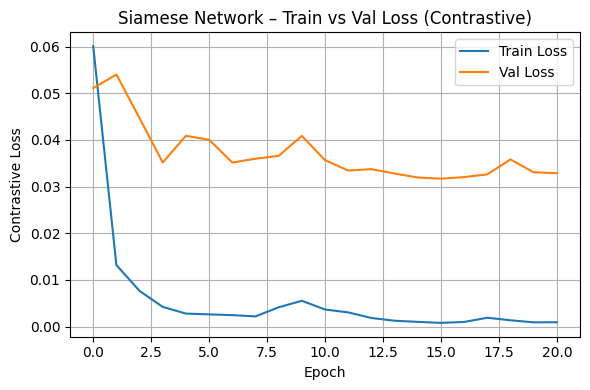

<Figure size 500x500 with 0 Axes>

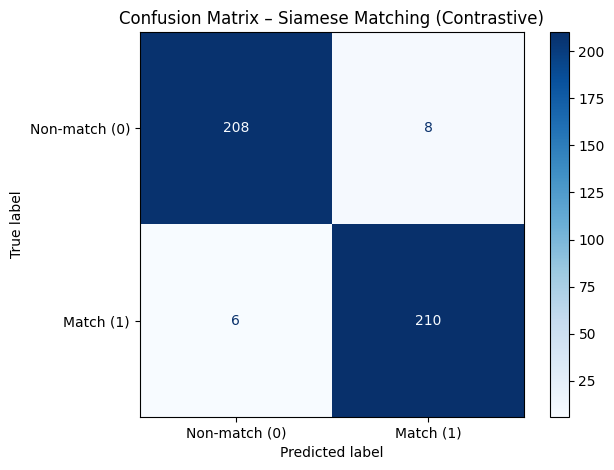

: 

In [ ]:
# =========================================================
# 8. EVALUATION + PLOTS (SNN)
# =========================================================
from sklearn.metrics import accuracy_score

# Final train / val loss from history
final_train_loss = history_snn.history["loss"][-1]
final_val_loss   = history_snn.history["val_loss"][-1]

# Test loss from Keras evaluate (only loss now)
test_loss = siamese_model.evaluate(
    [test_pairs[0], test_pairs[1]], y_test_pairs, verbose=0
)

print("\n============= SIAMESE MATCHING METRICS (Contrastive) =============")
print(f"Train Loss: {final_train_loss:.4f}")
print(f"Val   Loss: {final_val_loss:.4f}")
print(f"Test  Loss: {test_loss:.4f}")

# ---- Compute accuracy manually from distances + threshold ----
# Train predictions
train_dist = siamese_model.predict(
    [train_pairs[0], train_pairs[1]], verbose=0
).reshape(-1)

# Test predictions
test_dist = siamese_model.predict(
    [test_pairs[0], test_pairs[1]], verbose=0
).reshape(-1)

threshold = 0.5   # tune this later

y_train_pred = (train_dist < threshold).astype(int)  # smaller distance → match (1)
y_test_pred  = (test_dist  < threshold).astype(int)

train_acc = accuracy_score(y_train_pairs.astype(int), y_train_pred)
test_acc  = accuracy_score(y_test_pairs.astype(int),  y_test_pred)

print(f"Train Accuracy (thr={threshold}): {train_acc:.4f}")
print(f"Test  Accuracy (thr={threshold}): {test_acc:.4f}")
print("==================================================================\n")

# For the rest of the code, use test_dist instead of y_test_proba
y_test_dist = test_dist
print("Classification report (SNN match/non-match):")
print(classification_report(y_test_pairs.astype(int), y_test_pred))

cm_snn = confusion_matrix(y_test_pairs.astype(int), y_test_pred)
print("Confusion matrix (SNN):")
print(cm_snn)

# 8.1 Train vs Val loss
plt.figure(figsize=(6,4))
plt.plot(history_snn.history["loss"], label="Train Loss")
plt.plot(history_snn.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Contrastive Loss")
plt.title("Siamese Network – Train vs Val Loss (Contrastive)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# You can REMOVE the old 8.2 accuracy plot, since history has no accuracy now.
# (Or keep it commented out.)

# 8.3 Confusion matrix plot
plt.figure(figsize=(5,5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_snn,
    display_labels=["Non-match (0)", "Match (1)"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Siamese Matching (Contrastive)")
plt.tight_layout()
plt.show()


In [30]:
# =========================================================
# 10. VERIFICATION (single image) – U-Net + SNN (Contrastive)
# =========================================================
import os
import glob
import numpy as np
from PIL import Image

def _load_and_normalize_img(img_path, img_size=(256, 256)):
    """
    Load an image, convert to grayscale, resize, and normalize to [0,1].
    Returns: (H, W, 1) float32 array.
    """
    img = Image.open(img_path).convert("L").resize(img_size)
    arr = np.array(img, dtype=np.float32) / 255.0      # (H, W)
    return arr[..., np.newaxis]                        # (H, W, 1)


def verify_image_snn(
    unet_model,
    siamese_model,
    img_path,
    claimed_person_name,
    label_names,
    reference_root="../Multispectral Palmprint Database/NIR",
    img_size=(256, 256),
    threshold=0.5,
):
    """
    Verify if the image at img_path belongs to claimed_person_name
    using U-Net + Siamese Network (contrastive loss).

    Internally:
      - Picks ONE reference image for claimed_person_name from reference_root
      - Segments both images with U-Net
      - Computes distance with SNN
      - Uses a distance threshold for True/False.

    Args:
        unet_model        : trained U-Net model.
        siamese_model     : trained Siamese model (outputs distance).
        img_path          : path to probe image to verify.
        claimed_person_name : string like "0003" (must match a folder name).
        label_names       : list of all person IDs used in training (e.g. ["0001","0002",...]).
        reference_root    : root folder where person subfolders are stored.
        img_size          : (H, W) used for resizing.
        threshold         : distance threshold:
                            dist < threshold → match (True),
                            dist >= threshold → non-match (False).

    Returns:
        is_match (bool)       : True if probe is considered that person.
        predicted_name (str)  : here we simply return claimed_person_name
                                if match, otherwise "non-match".
        similarity (float)    : similarity in [0,1], where higher = more similar.
                                (derived from distance: similarity = 1 / (1 + dist))
    """

    # 0) Optional check: claimed person exists in label_names
    if claimed_person_name not in label_names:
        raise ValueError(f"claimed_person_name '{claimed_person_name}' "
                         f"not in label_names: {label_names}")

    # 1) Find a reference image for this person
    person_dir = os.path.join(reference_root, claimed_person_name)
    if not os.path.isdir(person_dir):
        raise FileNotFoundError(f"Person directory not found: {person_dir}")

    ref_paths = []
    for ext in ("*.bmp", "*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff"):
        ref_paths.extend(glob.glob(os.path.join(person_dir, ext)))

    if not ref_paths:
        raise FileNotFoundError(f"No reference images found in {person_dir}")

    # Use the first image as reference (you can change this strategy later)
    ref_img_path = sorted(ref_paths)[0]

    # 2) Load + normalize both images
    probe_img = _load_and_normalize_img(img_path, img_size)     # (H, W, 1)
    ref_img   = _load_and_normalize_img(ref_img_path, img_size) # (H, W, 1)

    probe_batch = probe_img[np.newaxis, ...]   # (1, H, W, 1)
    ref_batch   = ref_img[np.newaxis, ...]     # (1, H, W, 1)

    # 3) Predict masks with U-Net
    probe_mask = unet_model.predict(probe_batch, verbose=0)  # (1, H, W, 1)
    ref_mask   = unet_model.predict(ref_batch,   verbose=0)  # (1, H, W, 1)

    # 4) Binarise masks (same as in training pipeline)
    probe_mask_bin = (probe_mask >= 0.5).astype(np.float32)
    ref_mask_bin   = (ref_mask   >= 0.5).astype(np.float32)

    # 5) Siamese prediction: distance between embeddings
    dist = float(
        siamese_model.predict([ref_mask_bin, probe_mask_bin], verbose=0)[0, 0]
    )

    # 6) Decision: smaller distance = more likely match
    is_match = dist < threshold

    # Convert distance to a similarity score in [0,1] (optional, just for nicer output)
    dist_clipped = max(dist, 0.0)
    similarity = 1.0 / (1.0 + dist_clipped)

    if is_match:
        predicted_name = claimed_person_name
    else:
        predicted_name = "non-match"

    return is_match, predicted_name, similarity



#example:
test_img_path = "../Multispectral Palmprint Database/NIR/0003/2_05.jpg"

is_match, pred_name, sim = verify_image_snn(
    unet_model=unet,
    siamese_model=siamese_model,
    img_path=test_img_path,
    claimed_person_name="0003",        # claimed identity
    label_names=label_names,           # from your dataset loading
    reference_root="../Multispectral Palmprint Database/NIR",
    img_size=(256, 256),
    threshold=0.5                      # tune this based on validation
)

print("Match:", is_match)
print("Predicted name:", pred_name)
print("Similarity:", sim)


Match: True
Predicted name: 0003
Similarity: 0.9922643764700873
